# LoFi v.s. subspaceEKF

In [22]:
import jax
import einops
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from typing import Callable
from jax.flatten_util import ravel_pytree
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter.subspace_filter import subcify
from rebayes.low_rank_filter import lofi
from rebayes.sgd_filter import replay_sgd
from rebayes.datasets.datasets import load_mnist

In [23]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
res = load_mnist()
res = jax.tree_map(jnp.array, res)
(X_train, y_train), (X_test, y_test) = res
X_train = einops.rearrange(X_train, "obs width height -> obs (width height)")
X_test = einops.rearrange(X_test, "obs width height -> obs (width height)")

y_train_ohe = jax.nn.one_hot(y_train, 10)
y_test_ohe = jax.nn.one_hot(y_test, 10)

In [25]:
num_obs = 10_000

In [26]:
class NNet(nn.Module):
    activation: Callable = nn.elu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x

In [27]:
key = jax.random.PRNGKey(314)
model = NNet()
params_init = model.init(key, X_train[:10])
params_init_flat, _ = ravel_pytree(params_init)

## LoFi agent

In [9]:
def callback(bel, pred_obs, t, Xt, Yt, bel_pred, **kwargs):    
    # eval on all tasks test set
    yhat = agent.emission_mean_function(bel.mean, X_test).argmax(axis=1)
    acc = jnp.mean(yhat == y_test)
    
    out = {
        "acc": acc
    }
    
    return out

In [10]:
agent, recfn = lofi.init_classification_agent(
    model,
    X_train[:10],
    dynamics_weights=1.0,
    dynamics_covariance=1e-6,
    memory_size=20,
)

In [28]:
%%time
bel, outputs = agent.scan(
    initial_mean=params_init_flat,
    initial_covariance=1e-4,#1e-2,
    X=X_train[:num_obs],
    Y=y_train_ohe[:num_obs],
    progress_bar=False,
    callback=callback,
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)
acc_lofi = outputs["acc"]

CPU times: user 1min 10s, sys: 2.88 s, total: 1min 12s
Wall time: 2min 22s


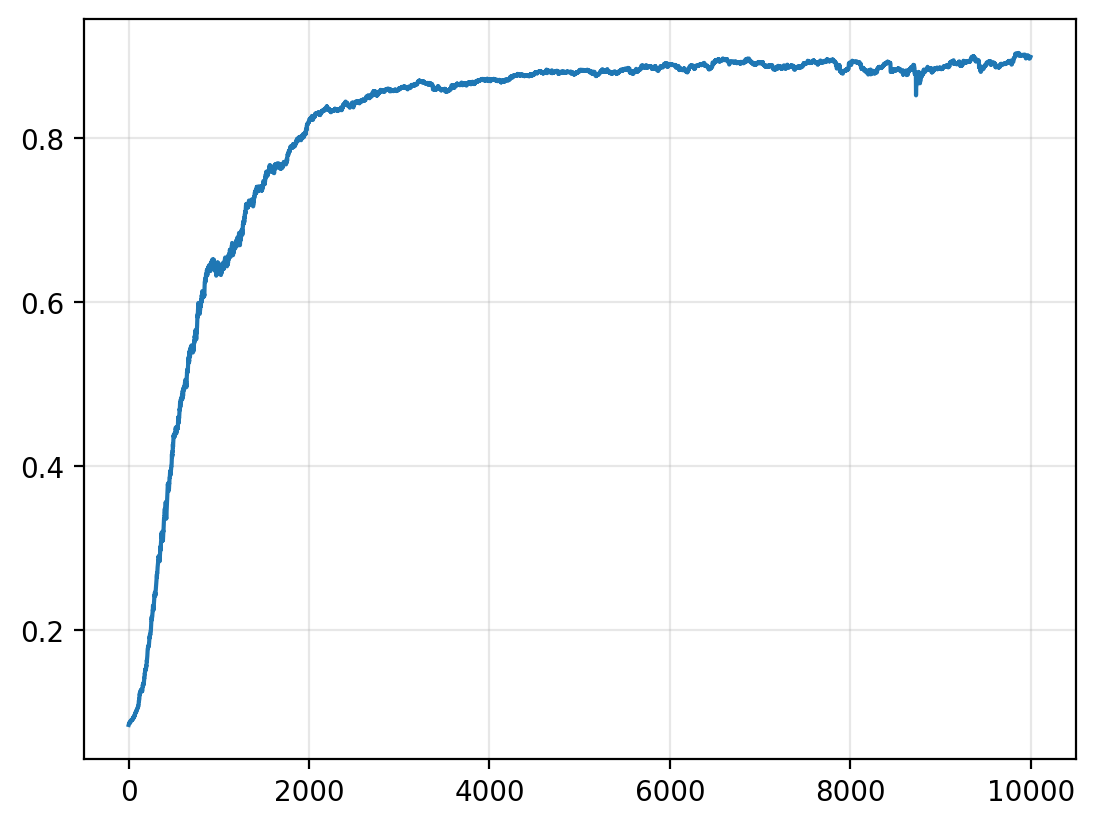

In [29]:
plt.plot(acc_lofi)
plt.grid(alpha=0.3)

In [30]:
agent.predict_obs(bel, X_test).argmax(axis=1)

Array([7, 5, 1, ..., 4, 5, 6], dtype=int32)

In [31]:
yhat_test = agent.predict_obs(bel, X_test).argmax(axis=1)
(yhat_test == y_test).mean()

Array(0.8987, dtype=float32)

## Subspace agent

In [32]:
SubNNet = subcify(NNet)
dim_in = 28 ** 2

dim_subspace = 20
model_sub = SubNNet(dim_in, dim_subspace=dim_subspace)

params_init = model_sub.init(key, X_train[:10])
params_init_flat, _ = ravel_pytree(params_init)

In [33]:
P = params_init["fixed"]["P"]
P = P / jnp.linalg.norm(P, axis=0) * 10

params_init["fixed"]["P"] = P

In [34]:
pfixed, psubspace_init = params_init["fixed"], params_init["params"]
psubspace_init_flat, recfn = ravel_pytree(psubspace_init)

In [35]:
def applyfn(psubspace, X):
    pfull = {
        "fixed": pfixed,
        "params": psubspace
    }
    return model_sub.apply(pfull, X)

In [36]:
dynamics_weights=1.0
dynamics_covariance=1e-6
method="fcekf"

def apply_fn(flat_params, x):
    return applyfn(recfn(flat_params), x)

def emission_cov_fn(flat_params, x, eps=1e-6):
    p = apply_fn(flat_params, x).ravel()
    return jnp.diag(p) - jnp.outer(p, p) + eps * jnp.eye(len(p))

agent = ekf.RebayesEKF(
    dynamics_weights_or_function=dynamics_weights,
    dynamics_covariance=dynamics_covariance,
    emission_mean_function=apply_fn,
    emission_cov_function=emission_cov_fn,
    adaptive_emission_cov=False,
    emission_dist=lambda mean, cov: tfd.Categorical(probs=mean),
    method=method,
)

In [37]:
key_new = jax.random.PRNGKey(271)
# psubspace_init_flat = jax.random.normal(key, ) * 2
psubspace_init_flat = jax.random.uniform(key_new, (dim_subspace,), minval=-2, maxval=2)

In [38]:
%%time
bel, outputs = agent.scan(
    initial_mean=psubspace_init_flat,
    initial_covariance=1e-1,
    X=X_train[:num_obs],
    Y=y_train_ohe[:num_obs],
    progress_bar=False,
    callback=callback
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)
acc_subekf = outputs["acc"]

CPU times: user 36.9 s, sys: 741 ms, total: 37.7 s
Wall time: 1min 12s


Array(0.2686, dtype=float32)

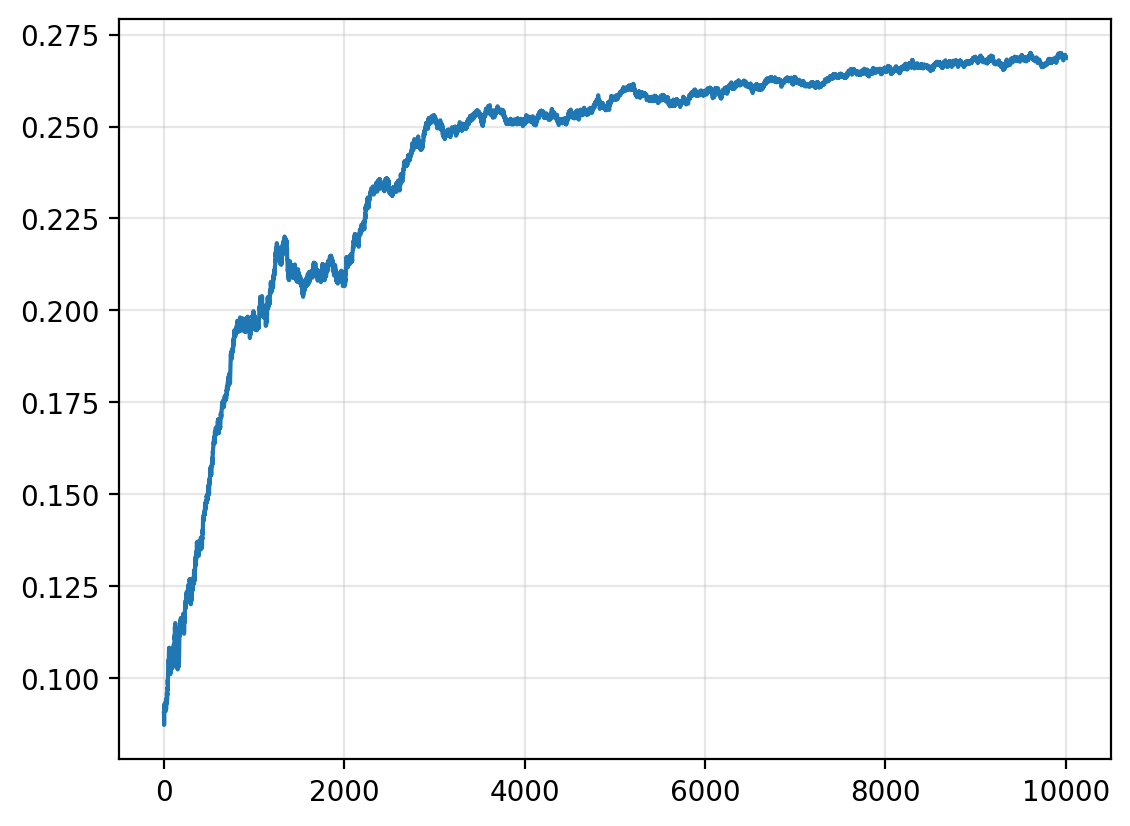

In [39]:
plt.plot(acc_subekf)
plt.grid(alpha=0.3)

yhat_test = apply_fn(bel.mean, X_test).argmax(axis=1)
(yhat_test == y_test).mean()

## Subspace method with last layer

In [40]:
@subcify
class NNetFT(nn.Module):
    activation: Callable = nn.elu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        return x

    
class PULSE(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = NNetFT(dim_in, dim_subspace)(x)
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x

In [41]:
model_ll = PULSE()
params_init = model_ll.init({"params": key, "fixed": key}, X_train[:10])

In [42]:
params_init_flat, _ = ravel_pytree(params_init)

In [43]:
jax.tree_map(jnp.shape, params_init)

{'fixed': {'SubspaceModule_0': {'P': (663200, 20), 'b': (663200,)}},
 'params': {'Dense_0': {'bias': (10,), 'kernel': (100, 10)},
  'SubspaceModule_0': {'subspace': (20,)}}}

In [44]:
pfixed, psubspace_init = params_init["fixed"], params_init["params"]

In [45]:
ps_flat = jax.random.uniform(key_new, (dim_subspace,), minval=-2, maxval=2)
psubspace_init["SubspaceModule_0"]["subspace"] = ps_flat
psubspace_init_flat, recfn = ravel_pytree(psubspace_init)

In [46]:
def applyfn(params, X):
    pfull = {
        "fixed": pfixed,
        "params": params
    }
    return model_ll.apply(pfull, X)

In [47]:
dynamics_weights=1.0
dynamics_covariance=1e-6
method="fcekf"

def apply_fn(flat_params, x):
    return applyfn(recfn(flat_params), x)

def emission_cov_fn(flat_params, x, eps=1e-6):
    p = apply_fn(flat_params, x).ravel()
    return jnp.diag(p) - jnp.outer(p, p) + eps * jnp.eye(len(p))

agent = ekf.RebayesEKF(
    dynamics_weights_or_function=dynamics_weights,
    dynamics_covariance=dynamics_covariance,
    emission_mean_function=apply_fn,
    emission_cov_function=emission_cov_fn,
    adaptive_emission_cov=False,
    emission_dist=lambda mean, cov: tfd.Categorical(probs=mean),
    method=method,
)

In [48]:
%%time
bel, outputs = agent.scan(
    initial_mean=psubspace_init_flat,
    initial_covariance=1e-2,
    X=X_train[:num_obs],
    Y=y_train_ohe[:num_obs],
    progress_bar=False,
    callback=callback
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)
acc_subllekf = outputs["acc"]

CPU times: user 43 s, sys: 839 ms, total: 43.8 s
Wall time: 1min 11s


Array(0.8425, dtype=float32)

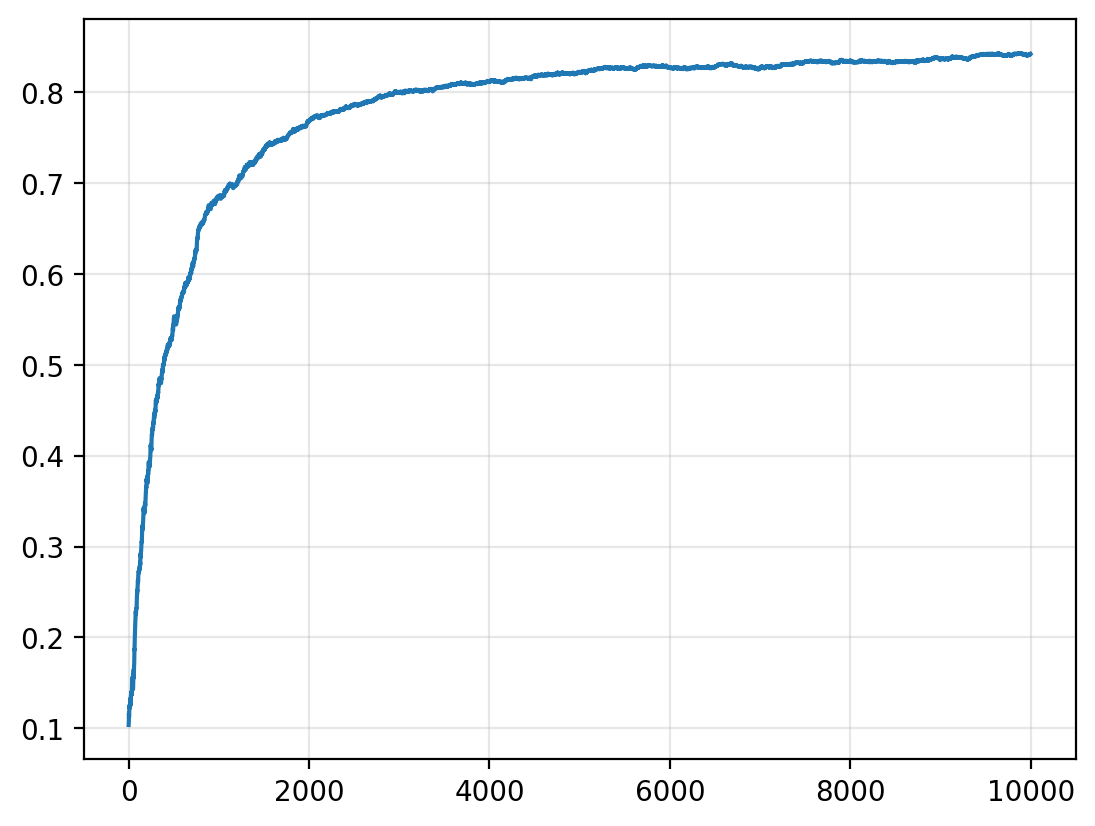

In [49]:
plt.plot(acc_subllekf)
plt.grid(alpha=0.3)

yhat_test = apply_fn(bel.mean, X_test).argmax(axis=1)
(yhat_test == y_test).mean()

## Comparison

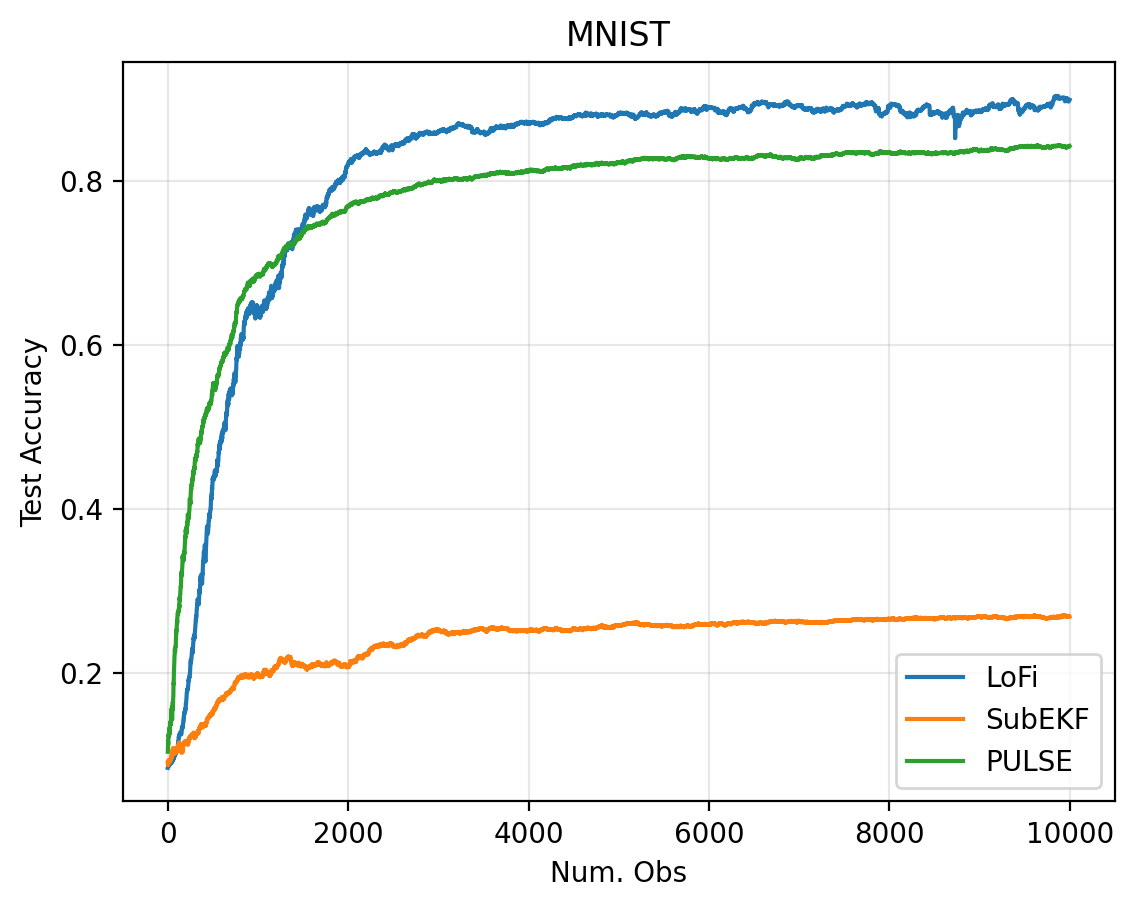

In [50]:
plt.plot(acc_lofi, label="LoFi")
plt.plot(acc_subekf, label="SubEKF")
plt.plot(acc_subllekf, label="PULSE")
plt.legend()
plt.xlabel("Num. Obs")
plt.ylabel("Test Accuracy")
plt.title("MNIST")
plt.grid(alpha=0.3)

## Replay buffer SGD

In [51]:
import optax

In [66]:
def callback(bel, pred_obs, t, Xt, Yt, bel_pred, **kwargs):    
    # eval on all tasks test set
    yhat = agent.apply_fn(bel.mean, X_test).argmax(axis=1)
    acc = jnp.mean(yhat == y_test)
    
    out = {
        "acc": acc
    }
    
    return out

In [63]:
model = NNet()
params_init = model.init(key, X_train[:10])

In [71]:
tx = optax.adam(1e-6)

In [72]:
_, dim_features = X_train.shape
_, dim_output = y_train_ohe.shape

In [76]:
agent = replay_sgd.FifoSGD(
    lossfn=replay_sgd.lossfn_xentropy,
    apply_fn=model.apply,
    tx=tx,
    buffer_size=20,
    dim_features=dim_features,
    dim_output=dim_output,
    n_inner=5,
)

In [77]:
%%time
bel, outputs = agent.scan(
    initial_mean=params_init,
    initial_covariance=1e-2,
    X=X_train[:num_obs],
    Y=y_train_ohe[:num_obs],
    progress_bar=False,
    callback=callback
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)
acc_replaysgd = outputs["acc"]

CPU times: user 9.88 s, sys: 99.7 ms, total: 9.98 s
Wall time: 37.7 s


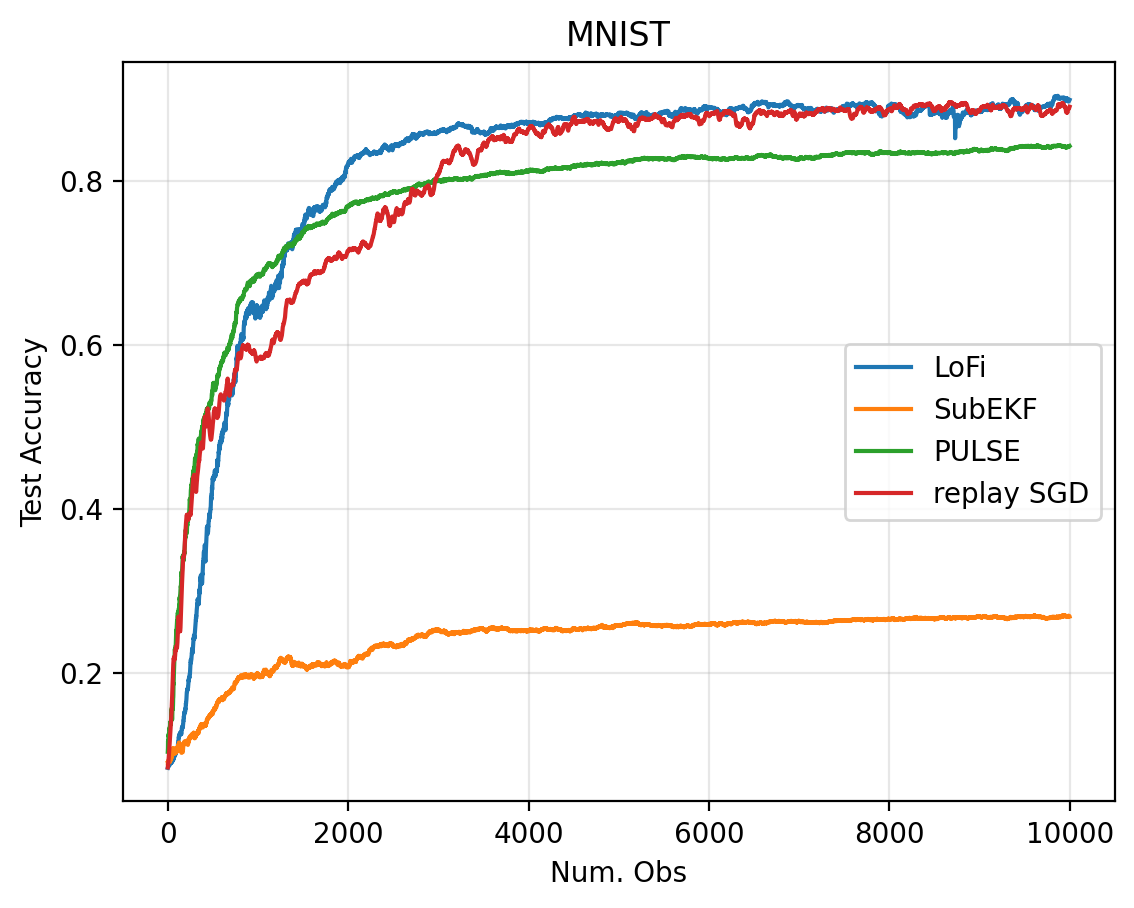

In [78]:
plt.plot(acc_lofi, label="LoFi")
plt.plot(acc_subekf, label="SubEKF")
plt.plot(acc_subllekf, label="PULSE")
plt.plot(acc_replaysgd, label="replay SGD")
plt.legend()
plt.xlabel("Num. Obs")
plt.ylabel("Test Accuracy")
plt.title("MNIST")
plt.grid(alpha=0.3)